# VAE Training - Faces dataset
Variational Autoencoders (VAEs). In a nutshell, a VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. Moreover, the term “variational” comes from the close relation there is between the regularisation and the variational inference method in statistics.



## imports

In [ ]:
import os
from glob import glob
import numpy as np

from models.VAE import VariationalAutoencoder
from keras.preprocessing.image import ImageDataGenerator

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including
<ul>
<li>
10,177 number of identities,</li>
<li>
202,599 number of face images, and
</li>
<li>
5 landmark locations, 40 binary attributes annotations per image.</li>
</ul>

Below you can see the sample images

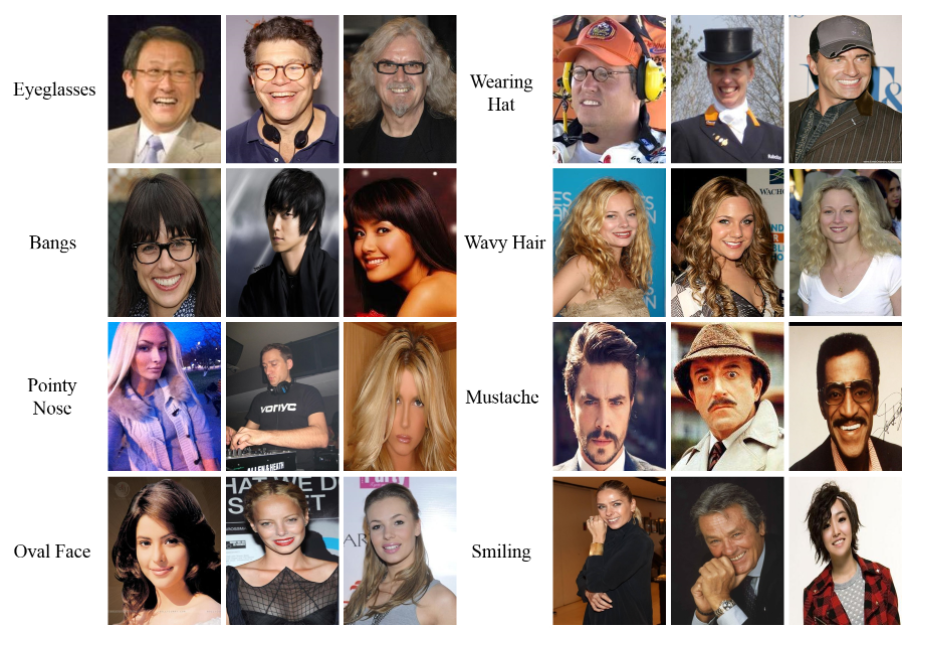

In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


DATA_FOLDER = './data/celeb/'

## data

In [3]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)

In [4]:
#We use a generator to feed images to the VAE from a folder, rather than loading all the images into memory up front. 
#Since the VAE trains in batches, there is no need to load all the images into memory first
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


## architecture

In [ ]:
#In comparison with minst dataset the data is much more complex.So, the dimensionality of the latent space has been increased. 
#So, that the network can encode a satisfactory amount of detail from the images.
#In the architecture there are batch normalization layers after each convolution layer to speed up training.
#Even though each batch takes a longer time to run, the number of batches required to reach the same loss is greatly reduced.
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [ ]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [ ]:
#As you can see in the layers the number of channels in the final convolutional transpose layer is 3.
#Because the data has 3 input channels(RGB).
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
__________

## training

In [ ]:
LEARNING_RATE = 0.0005
# Reconstruction loss factor is a parameter that requires tuning; 
#for this dataset and architecture this value was found to generate good results.
R_LOSS_FACTOR = 10000
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [ ]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [ ]:
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200
1050/6331 [===>..........................] - ETA: 4:01:12 - loss: 240.7929 - vae_r_loss: 182.2923 - vae_kl_loss: 58.5006